<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/classification_option1_chexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hybrid model
  This notebook is trying to build option-1 which includes classification followed by detection.

Classification:
  1. **ChexNet- Densnet121** - This has been implemented here.
  2. VGG NET
  3. InceptionV3
  4. InceptionRestNetV2

Detection:
  RetinaNet based architecture
  1. ResNet101 
  2. ResNet152

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [ ]:
#Set global parameters here
BASE_MODEL = "DenseNet121"
MODEL_NAME  = "Option-1" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history.csv"
BATCH_SIZE = 16
IMAGE_SIZE = 224 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training
DROPOUT = 0.25 # [0, 0.25, 0.5]
DENSE_COUNT = 128 # [32, 64, 128, 256]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
ALPHA = 1.0
EPOCHS = 5

In [ ]:
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
     |████████████████████████████████| 35.5MB 89kB/s 
Setting baseModel : DenseNet121
<module 'tensorflow.keras.applications.densenet' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/densenet/__init__.py'>
global BaseModel; BaseModel =np.DenseNet121
global preprocess_input; preprocess_input =np.preprocess_input
<class 'function'>
/content/drive/My Drive/rsna-pneumonia-detection-challenge
<function DenseNet121 at 0x7fadabb2b6a8> <function preprocess_input at 0x7fadabb2b840>


In [ ]:
baseModel,preprocess_input

(<function tensorflow.python.keras.applications.densenet.DenseNet121>,
 <function tensorflow.python.keras.applications.densenet.preprocess_input>)

In [ ]:

image_shape = MODEL_MAP[BASE_MODEL]['input_shape']
IMAGE_SIZE = image_shape[0]
image_shape,IMAGE_SIZE

((224, 224, 3), 224)

In [ ]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


In [ ]:

# CLASS_VECTORS = get_class_map(full_df)

In [ ]:
full_df.head(2)

,Unnamed: 0,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...


In [ ]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

In [ ]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [ ]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df,target='class')

(21347, 14) training data
(5337, 14) raw validation data
(2668, 14) Validation data
(2669, 14) test data


In [ ]:
unbalanced_train_df[unbalanced_train_df.class_id == 0].shape[0]

4809

12624 Final training size


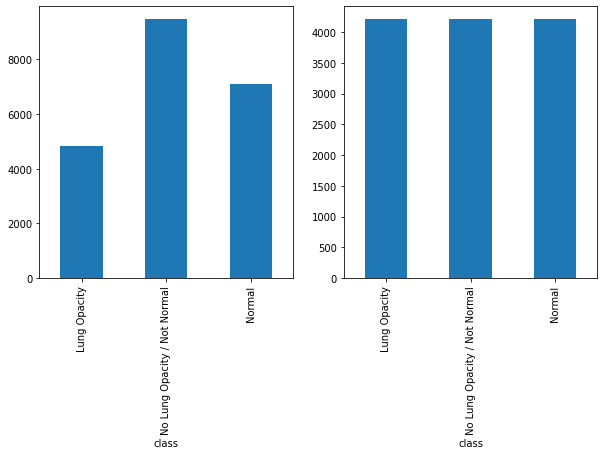

In [ ]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 12624 # 4208 x 3 class targets
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES,target='class')
print(train_df.shape[0], 'Final training size')

In [ ]:
train_df = pd.read_csv('classification_train_df.csv',converters={'class_vector':eval})
valid_df = pd.read_csv('classification_valid_df.csv',converters={'class_vector':eval})
test_df = pd.read_csv('classification_test_df.csv',converters={'class_vector':eval})

In [ ]:
y = train_df.class_vector[0]
type(y)

list

## Build model

In [ ]:
len(np.unique(train_df["path"].to_numpy()))

12624

In [ ]:
# BATCH_SIZE = 8
# IMAGE_SIZE = 224
# IMG_WIDTH = 1024
train_gen = MyLabelDataGenerator(train_df)
valid_gen = MyLabelDataGenerator(valid_df)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

12624 :No of generator Image
2668 :No of generator Image
789 # of iterations in one train epoch
166 # of iterations in one validate epoch


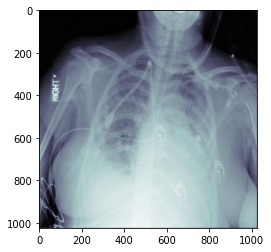

In [ ]:
path = bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('path')
img = train_gen.getImage(path)
plt.imshow(img, cmap=plt.cm.bone)

In [ ]:
imageSet = train_gen[9][0]
maskSet = train_gen[9][1]   #Label

In [ ]:
imageSet.shape,maskSet.shape

((16, 224, 224, 3), (16, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


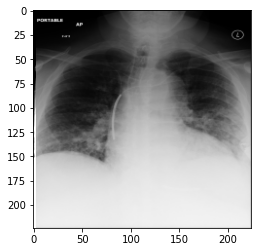

In [ ]:
plt.imshow(imageSet[9], cmap=plt.cm.bone)

In [ ]:

def build_pretrained_model():
  #Build base model
  input_shape = MODEL_MAP[BASE_MODEL]['input_shape']
  base_pretrained_model = BaseModel(input_shape =  input_shape, 
                              include_top = False, weights = 'imagenet')
  base_pretrained_model.trainable = False
  #Build Top layer
  lastlayer = MODEL_MAP[BASE_MODEL]['last_conv_layer']
  lastlayershape = base_pretrained_model.get_layer(lastlayer).output_shape[1:]
  pt_features = Input(lastlayershape, name = 'feature_input')
    
  bn_features = BatchNormalization()(pt_features)
  gap = GlobalAveragePooling2D()(bn_features)

  gap_dr = Dropout(DROPOUT)(gap)
  dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
  dr_steps = BatchNormalization()(dr_steps)
  dr_steps = layers.LeakyReLU(0.1)(dr_steps)
  out_layer = Dense(3, activation = 'softmax')(dr_steps)

  attn_model = Model(inputs = [pt_features], 
                    outputs = [out_layer], name = 'top_model')
  #Combine base & top model
  pneu_model = Sequential(name = 'combined_model')
  # base_pretrained_model.trainable = False
  pneu_model.add(base_pretrained_model)
  pneu_model.add(attn_model)
  #Add loss & optimizer
  lr = LEARN_RATE
  decay = lr/10 # or in the factor of 10
  adamOptimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
  pneu_model.compile(optimizer =adamOptimizer, loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
  
  return pneu_model,base_pretrained_model,attn_model

In [ ]:
class_model,base_model,top_model = build_pretrained_model()
class_model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
top_model (Functional)       (None, 3)                 136067    
Total params: 7,173,571
Trainable params: 133,763
Non-trainable params: 7,039,808
_________________________________________________________________


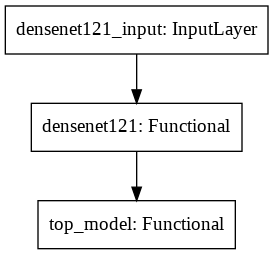

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(class_model)

In [ ]:
checkpoint = ModelCheckpoint(WEIGHTS_FILE, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

##Model Fit

In [ ]:
%%time
history = pd.DataFrame()

if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  class_model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    class_model.load_weights(WEIGHTS_FILE)
  history = class_model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=callbacks_list,
                        shuffle=True,
                        verbose=1)
  
  history = saveHistory(history,HISTORY_FILE)

CPU times: user 504 ms, sys: 87.9 ms, total: 591 ms
Wall time: 584 ms


## History

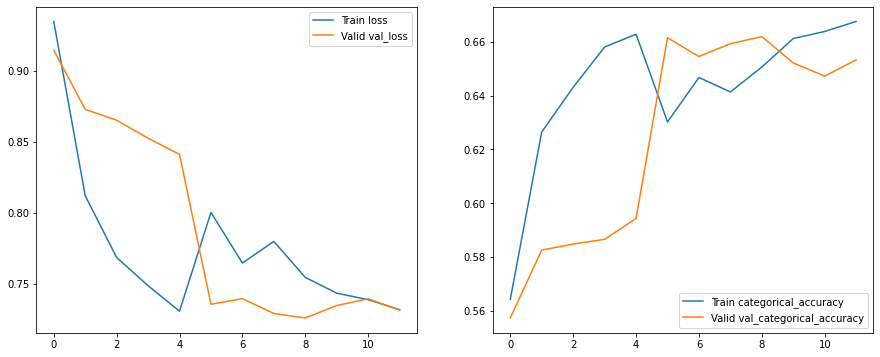

In [ ]:
plot_his(history,'categorical_accuracy')
#Save the model as well for future use

## Classification-Stage1 performance

In [ ]:
predict_gen = MyLabelTestDataGenerator(train_df)

12624 :No of generator Image


In [ ]:
patients, pred_Y,valid_Y = class_predict(predict_gen,class_model,no_of_batch=0)

100%|██████████| 789/789 [2:21:11<00:00, 10.74s/it]


                              precision    recall  f1-score   support

                Lung Opacity       0.71      0.71      0.71      4208
No Lung Opacity / Not Normal       0.60      0.51      0.55      4208
                      Normal       0.75      0.86      0.80      4208

                    accuracy                           0.69     12624
                   macro avg       0.69      0.69      0.69     12624
                weighted avg       0.69      0.69      0.69     12624



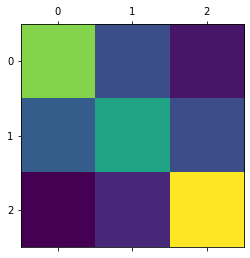

In [ ]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))

### ROC AUC

In [ ]:
type(valid_Y[0])

numpy.ndarray

In [ ]:
np.argmax(valid_Y,-1)==0

array([False,  True, False, ..., False, False,  True])

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score
# fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y)
# fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
# ax1.plot(fpr, tpr, 'b.-', label = 'DenseNet1 (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y))
# ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
# ax1.legend(loc = 4)
# ax1.set_xlabel('False Positive Rate')
# ax1.set_ylabel('True Positive Rate');
# ax1.set_title('Lung Opacity ROC Curve')

## Generate class prediction

In [ ]:
pred_df = get_prediction_map(patients,pred_Y)

In [ ]:
pred_df.reset_index(inplace=True)
# pred_df.columns = ['patientId', 'PNEUMONIA', 'NOT_NORMAL', 'NORMAL']

pred_df.rename(columns={'index':'patientId'},inplace=True)
pred_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL
0,81cc48ed-0b64-436e-809e-47c3fc35006f,0.060745,0.181098,0.758157
1,74075cca-a426-4710-92de-e23aa74b76ac,0.783721,0.190050,0.026228
2,d442daf0-cc56-4c05-8874-94712aa53704,0.313819,0.411228,0.274952
3,2bbcfa00-cfcb-4761-b3e3-83687fd65d5b,0.690628,0.289071,0.020301
4,c97fe65e-3d97-4941-ad80-70f745d7d41f,0.032692,0.160328,0.806980


In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12624 entries, 0 to 12623
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   12624 non-null  object 
 1   PNEUMONIA   12624 non-null  float64
 2   NOT_NORMAL  12624 non-null  float64
 3   NORMAL      12624 non-null  float64
dtypes: float64(3), object(1)
memory usage: 394.6+ KB


In [ ]:
pred_dump_file = MODEL_NAME + '/class_prediction.csv'
if (os.path.isfile(pred_dump_file)):
  os.remove(pred_dump_file)

In [ ]:
#Dump the prediction as it is very time consuming task.

import pandas as pd
# pred_df = pd.DataFrame()
if (os.path.isfile(pred_dump_file)):
  print("Loading prediction:",pred_dump_file)
  pred_df = pd.read_csv(pred_dump_file)
else:
  print("Dumping prediction:",pred_dump_file)
  pred_df.to_csv(pred_dump_file,index=False)

Dumping prediction: Option-1.DenseNet121/class_prediction.csv


In [ ]:
# pred_df.drop(pred_df.columns[0],inplace=True,axis=1)

In [ ]:
merged_pred_meta_df = get_pred_merged_meta_data(pred_df,full_df)
merged_pred_meta_df.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
81cc48ed-0b64-436e-809e-47c3fc35006f,0.060745,0.181098,0.758157,52.0,1.0,0.0,0.0
74075cca-a426-4710-92de-e23aa74b76ac,0.783721,0.190050,0.026228,50.0,1.0,0.0,1.0
d442daf0-cc56-4c05-8874-94712aa53704,0.313819,0.411228,0.274952,58.0,1.0,1.0,0.0
2bbcfa00-cfcb-4761-b3e3-83687fd65d5b,0.690628,0.289071,0.020301,80.0,0.0,1.0,1.0
c97fe65e-3d97-4941-ad80-70f745d7d41f,0.032692,0.160328,0.806980,35.0,1.0,1.0,0.0


In [ ]:
merged_pred_meta_df.reset_index(inplace=True)
merged_pred_meta_df.rename(columns={'index':'patientId'},inplace=True)
merged_pred_meta_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
0,81cc48ed-0b64-436e-809e-47c3fc35006f,0.060745,0.181098,0.758157,52.0,1.0,0.0,0.0
1,74075cca-a426-4710-92de-e23aa74b76ac,0.783721,0.190050,0.026228,50.0,1.0,0.0,1.0
2,d442daf0-cc56-4c05-8874-94712aa53704,0.313819,0.411228,0.274952,58.0,1.0,1.0,0.0
3,2bbcfa00-cfcb-4761-b3e3-83687fd65d5b,0.690628,0.289071,0.020301,80.0,0.0,1.0,1.0
4,c97fe65e-3d97-4941-ad80-70f745d7d41f,0.032692,0.160328,0.806980,35.0,1.0,1.0,0.0


In [ ]:
merged_pred_meta_df[merged_pred_meta_df.Target==1].sample(5)

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
5175,9131bb85-6251-4f0e-9ccb-4a4189f84087,0.650082,0.328029,0.021888,26.0,1.0,1.0,1.0
6069,830029b1-3429-48f3-b13d-c7c611865d6e,0.646471,0.216838,0.136691,6.0,1.0,1.0,1.0
12297,aef45568-9947-4c75-83d8-3643210d9c3b,0.509257,0.474935,0.015808,53.0,1.0,1.0,1.0
3382,f02e36df-ac4d-43f1-8001-3e0494145b0a,0.970737,0.029230,0.000033,24.0,1.0,1.0,1.0
1219,79fdfa10-9752-4ab8-a1ca-7f33037dd5aa,0.752080,0.229829,0.018092,19.0,0.0,1.0,1.0


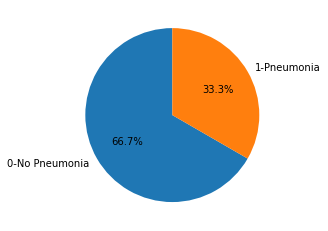

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
unique_values, count = np.unique(merged_pred_meta_df['Target'], return_counts=True)

plt.pie(count, labels = ['0-No Pneumonia', '1-Pneumonia'],
          autopct='%1.1f%%', startangle=90)
plt.show()
#Need to balance the data here.

In [ ]:
#Split the data into train & valid
y = merged_pred_meta_df['Target'].to_numpy()
X = merged_pred_meta_df[merged_pred_meta_df.columns[1:7]]

In [ ]:
X.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition
0,0.060745,0.181098,0.758157,52.0,1.0,0.0
1,0.783721,0.190050,0.026228,50.0,1.0,0.0
2,0.313819,0.411228,0.274952,58.0,1.0,1.0
3,0.690628,0.289071,0.020301,80.0,0.0,1.0
4,0.032692,0.160328,0.806980,35.0,1.0,1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## FFNN model

In [ ]:
#Build neural netwrok

from tensorflow.keras.layers import  Reshape
def add_layer(model):
  kinit ='he_normal' #tf.keras.initializers.he_normal()
  actv = 'relu' #activation.relu
  # model.add(Reshape((6,),input_shape=(32,32,)))
  # #Add batch normalization to avoid NAN in training loss
  # model.add(kl.normalization.BatchNormalization())
  #Add input layer -- 
  model.add(Dense(6,input_dim= 6,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #How many hidden layer? No clear rule, trial & error? Literature says, it 3 hidden layer sufficient
  #Add hidden layer -1
  model.add(Dense(16,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -2
  model.add(Dense(8,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -3
  model.add(Dense(4,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())


  #Add output layer -- number of output neoron 1(as the number of output is 10)
  #Add hidden layer -1
  model.add(Dense(1,activation='sigmoid',kernel_initializer=kinit))
  
nn_model = Sequential()
add_layer(nn_model)

In [ ]:
def fit_model(opt,model,epoch=60,verbo=1,batchsize=128):
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(X_train, y_train, validation_data=(X_test,y_test),batch_size=batchsize, epochs=epoch, verbose=verbo)
  return history
opt = Adam(lr = LEARN_RATE)
history = fit_model(opt,nn_model)

Epoch 1/60
89/89 [==============================] - 1s 10ms/step - loss: 0.7654 - accuracy: 0.5827 - val_loss: 0.7537 - val_accuracy: 0.6295
Epoch 2/60
89/89 [==============================] - 1s 7ms/step - loss: 0.7238 - accuracy: 0.6057 - val_loss: 0.7959 - val_accuracy: 0.5875
Epoch 3/60
89/89 [==============================] - 1s 8ms/step - loss: 0.6901 - accuracy: 0.6352 - val_loss: 0.8347 - val_accuracy: 0.5764
Epoch 4/60
89/89 [==============================] - 1s 8ms/step - loss: 0.6602 - accuracy: 0.6734 - val_loss: 0.8545 - val_accuracy: 0.5661
Epoch 5/60
89/89 [==============================] - 1s 7ms/step - loss: 0.6345 - accuracy: 0.7023 - val_loss: 0.7972 - val_accuracy: 0.5352
Epoch 6/60
89/89 [==============================] - 1s 8ms/step - loss: 0.6145 - accuracy: 0.7153 - val_loss: 0.6990 - val_accuracy: 0.5922
Epoch 7/60
89/89 [==============================] - 1s 7ms/step - loss: 0.5949 - accuracy: 0.7173 - val_loss: 0.6280 - val_accuracy: 0.7039
Epoch 8/60
89/89 [=

In [ ]:
HISTORY_FILE = MODEL_NAME+"/" +"history_FFNN.csv"
his_ffnn = saveHistory(history,HISTORY_FILE)

## Classification Performance(Recall)

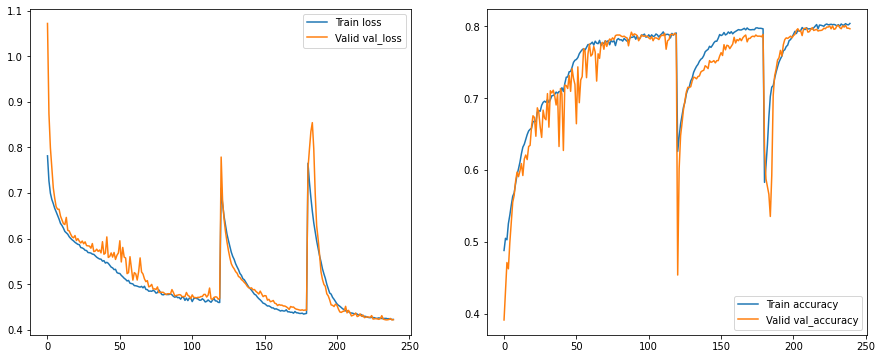

In [ ]:
plot_his(his_ffnn,'accuracy')

In [ ]:
pred_y = nn_model.predict(X_test)

In [ ]:
pred_y

array([[0.07010298],
       [0.05434309],
       [0.8722344 ],
       ...,
       [0.05962332],
       [0.2611385 ],
       [0.2099396 ]], dtype=float32)

In [ ]:
pred_y_class = (pred_y >= 0.45).astype(np.int)

In [ ]:
y_test = (y_test >= 0.5).astype(np.int)


In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(y_test, pred_y_class), "\n")
print("Classification Report:- \n", metrics.classification_report(y_test, pred_y_class))

Confusion Matrix:- 
 [[738 106]
 [147 272]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       844
           1       0.72      0.65      0.68       419

    accuracy                           0.80      1263
   macro avg       0.78      0.76      0.77      1263
weighted avg       0.80      0.80      0.80      1263



### ROC curve

Text(0.5, 1.0, 'Lung Opacity ROC Curve')

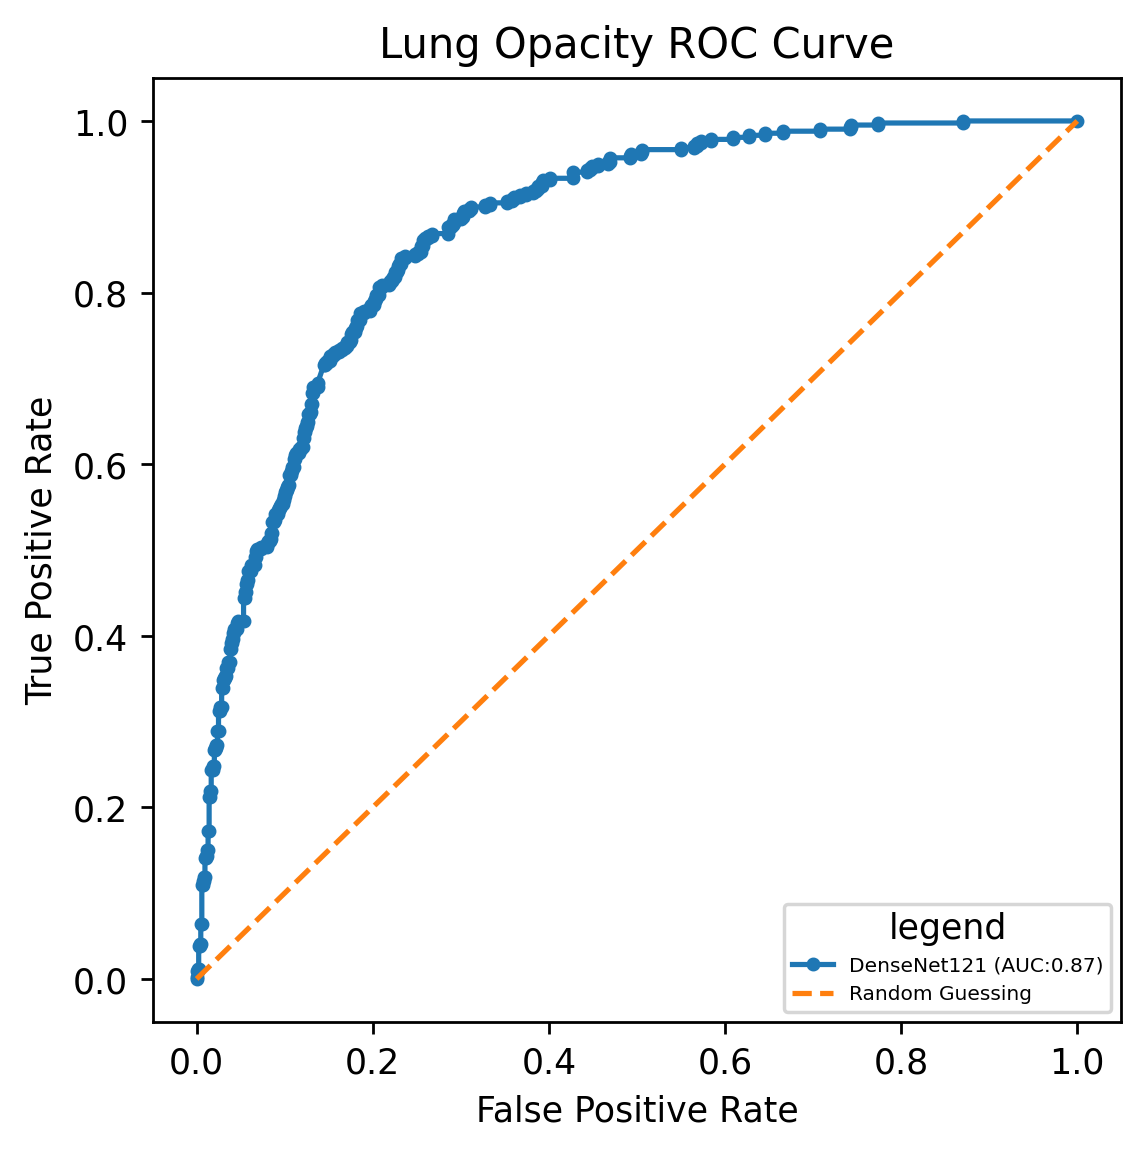

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')
fpr, tpr, _ = roc_curve(y_test, pred_y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, marker='.', label = 'DenseNet121 (AUC:%2.2f)' % roc_auc_score(y_test, pred_y))
ax1.plot(fpr, fpr, linestyle='--', label = 'Random Guessing')
ax1.legend(title='legend',  loc='lower right', prop=fontP)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')

## Conclusion